# Data Transformation

<br>

### Imports

In [12]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import os
import time
import FEAutils as hlp

import satpy
from satpy import Scene
from pyresample.geometry import AreaDefinition
import cartopy.crs as ccrs

<br>

### User Input

In [2]:
data_dir = '../data/raw'

<br>

### Exploratory Data Analysis

We'll start by identifying the available files

In [3]:
native_fps = sorted([f'{data_dir}/{f}' for f in os.listdir(data_dir) if '.nat' in f])

native_fps[0]

'../data/raw/MSG3-SEVI-MSG15-0100-NA-20201001000414.060000000Z-NA.nat'

<br>

Then load one of them in as a SatPy scene

In [4]:
scene = Scene(filenames=[native_fps[100]], reader='seviri_l1b_native')

scene

<br>

We can get a list of the available datasets (bands)

In [5]:
scene.all_dataset_names()

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

<br>

We can visualise what a specific band looks like

C:\Users\Ayrto\anaconda3\envs\sat_image_processing\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


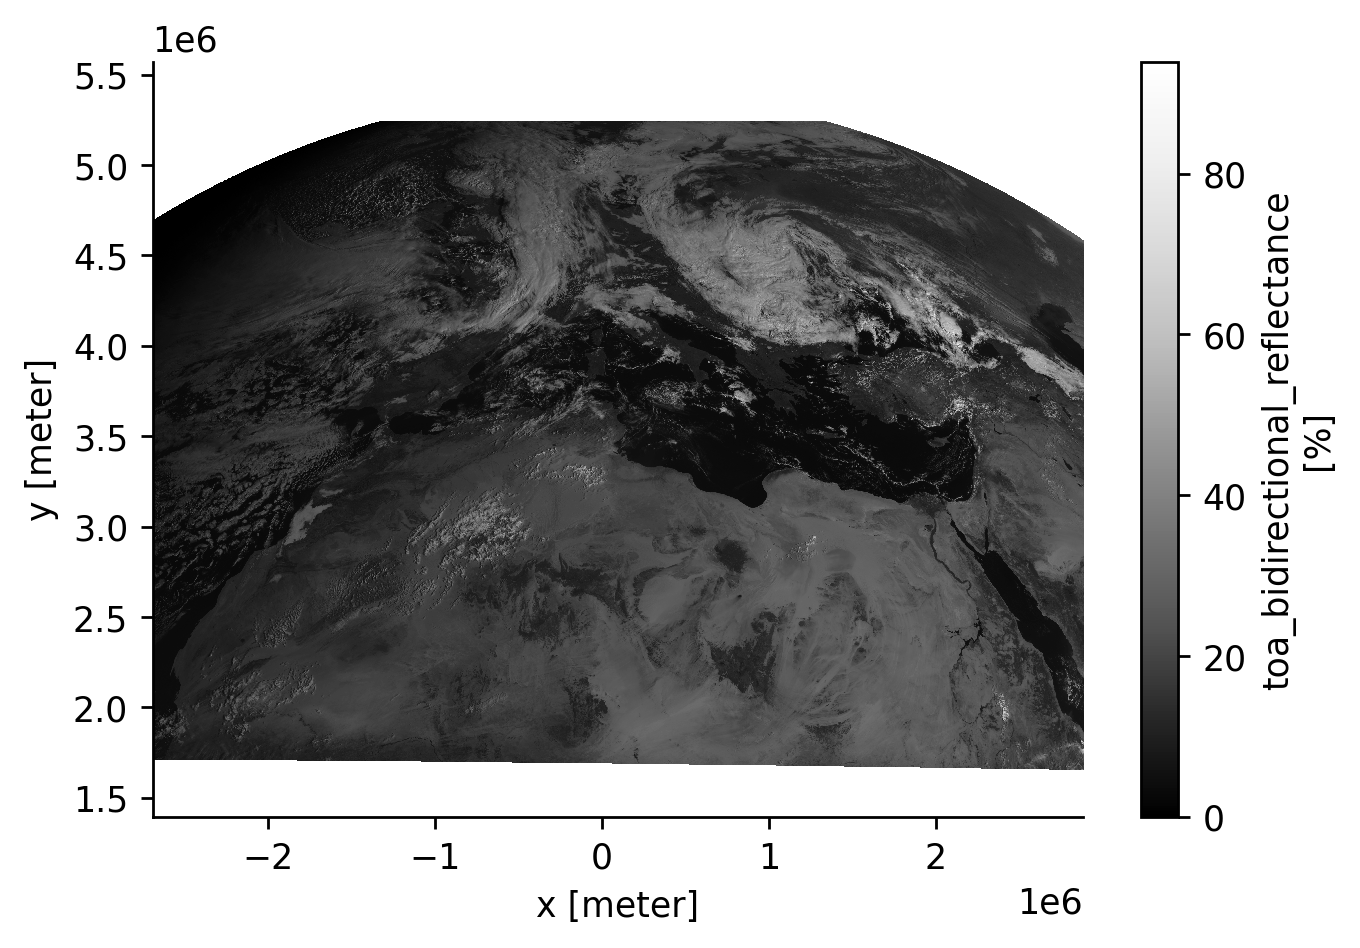

In [6]:
scene.load(['HRV'])

# Plotting
fig, ax = plt.subplots(dpi=250)

scene['HRV'].plot.imshow(ax=ax, cmap='Greys_r', vmin=0)

ax.set_title('')
hlp.hide_spines(ax)

<br>

One of the benefits of having access to the underlying XArray object is that we can more easily start to do some analysis with the data, for example defining a reflectance threshold

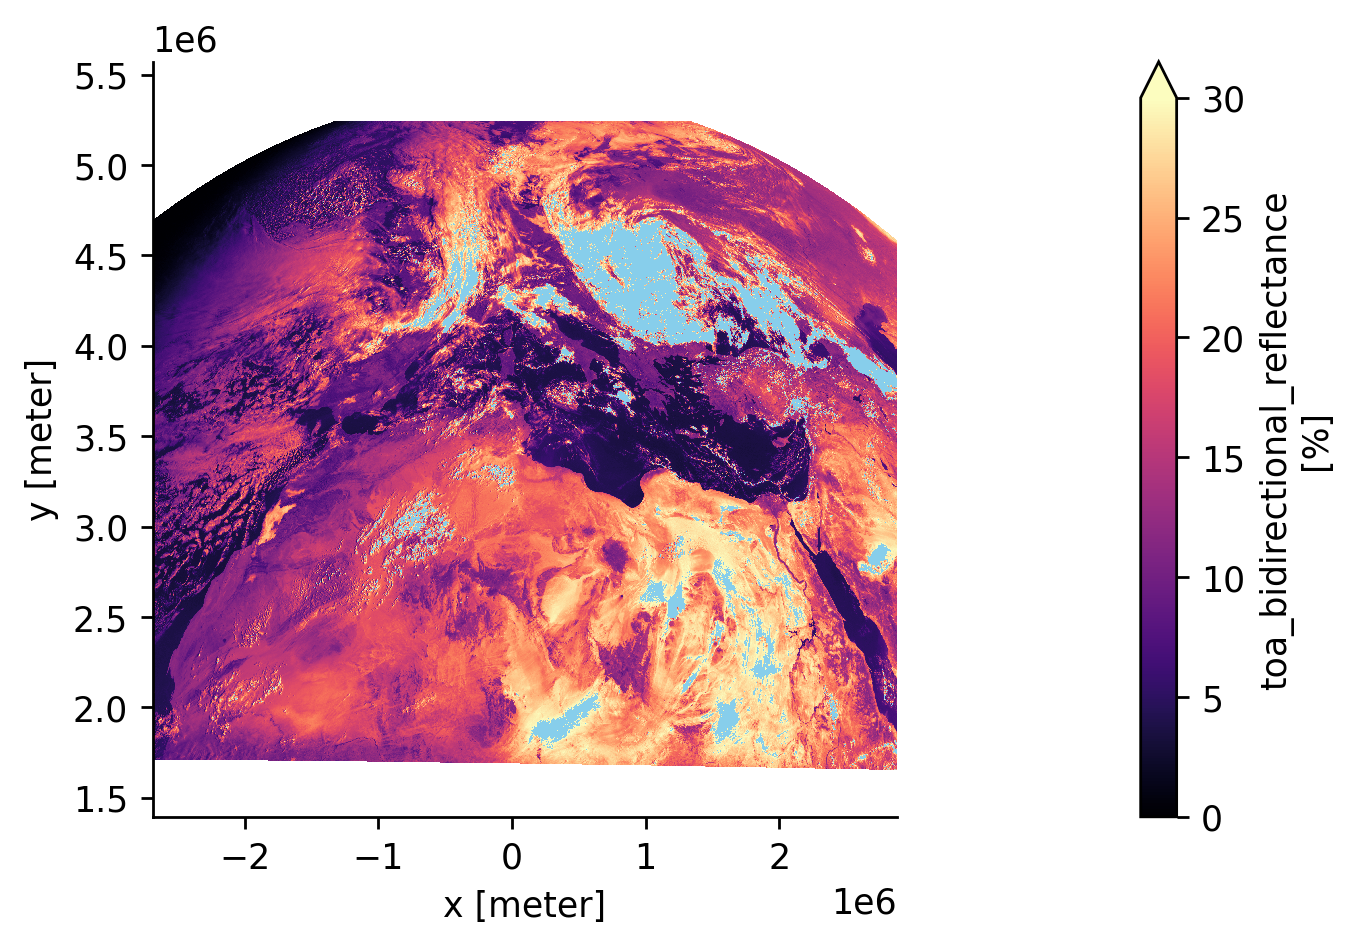

In [7]:
reflectance_threshold = 30

cmap = colors.ListedColormap([
    (0, 0, 0, 0), # transparent
    (0.533, 0.808, 0.922, 1) # grey-like blue
])

# Plotting
fig, ax = plt.subplots(dpi=250)

scene['HRV'].plot.imshow(ax=ax, vmin=0, vmax=reflectance_threshold, cmap='magma')
(scene['HRV']>reflectance_threshold).plot.imshow(ax=ax, cmap=cmap)

fig.delaxes(fig.axes[-1]) # deleting the second colorbar
ax.set_title('')
hlp.hide_spines(ax)

<br>

We'll extract the values from the XArray object, then mask all NaN values to enable us to carry out statistical analysis

In [8]:
HRV = scene["HRV"].values
HRV_masked = ma.masked_array(HRV, mask=xr.ufuncs.isnan(scene["HRV"]).values)

np.mean(HRV_masked)

16.437234512441318

<br>

We can also visualise the full distribution.

N.b. to reduce the time it takes to calculate the best KDE fit we'll take only a sample of the data.

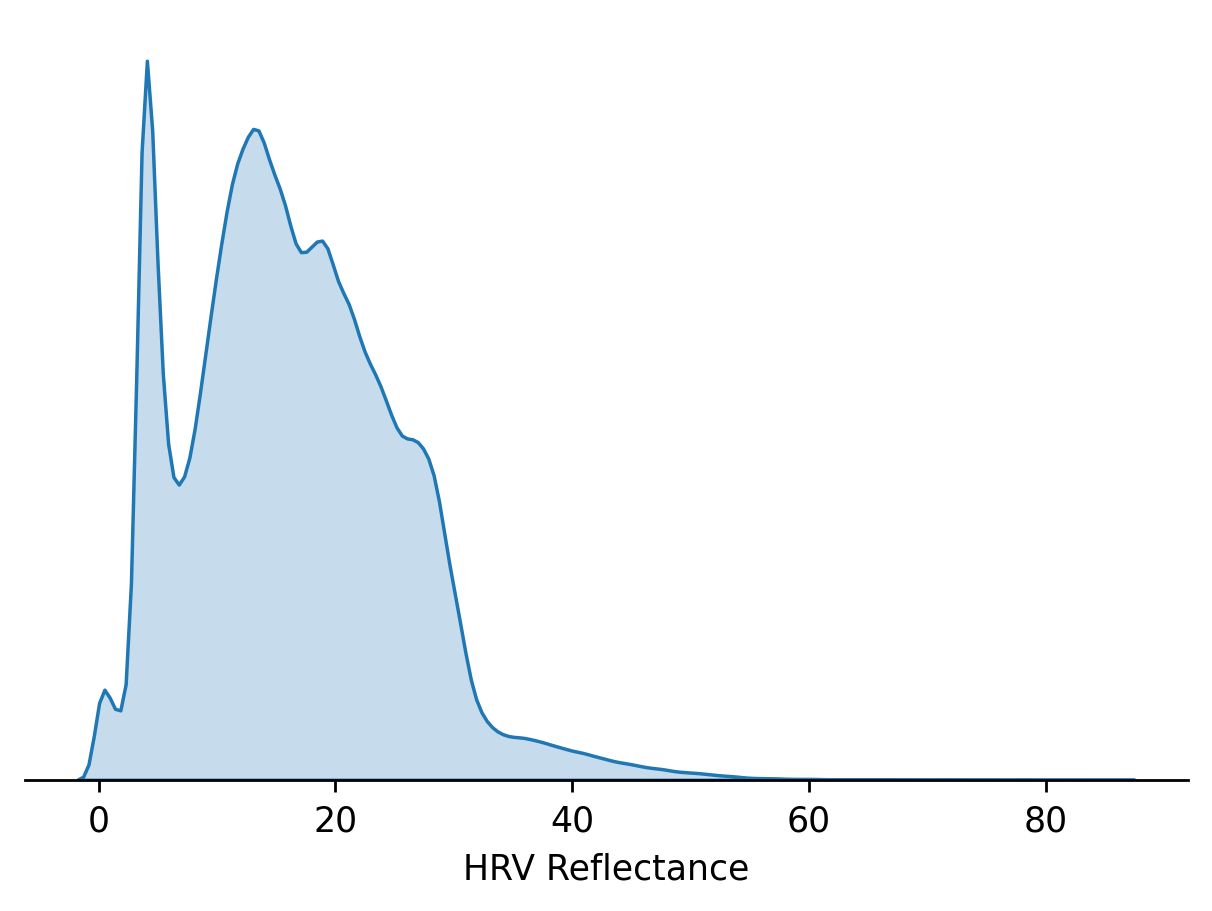

In [9]:
HRV_sample = np.random.choice(HRV_masked.flatten(), 1_000_000)

# Plotting
fig, ax = plt.subplots(dpi=250)

sns.kdeplot(HRV_sample, ax=ax, fill=True)

ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('HRV Reflectance')
hlp.hide_spines(ax, positions=['top', 'left', 'right'])

<br>

### Exploring Resampling Options

We'll start by resampling using the `pyresample` library

In [26]:
%%time

def pyresample_scene(area_id, description, 
                     proj_id, projection,
                     west, south, east, north,
                     meters_per_pixel, **resample_kwargs):
    
    width = int((east - west) / meters_per_pixel)
    height = int((north - south) / meters_per_pixel)
    area_extent = (west, south, east, north)

    area_def = AreaDefinition(area_id, description, 
                              proj_id, projection,
                              width, height, area_extent)

    resampled_scene = scene.resample(area_def, **resample_kwargs)
    
    return resampled_scene

meters_per_pixel = 1000
west, south, east, north = (-3090000, 1690000, 4390000, 9014000)

area_id = 'UTM-32N'
description = 'WGS 84 / UTM zone 32N'
proj_id = 'UTM-32N'

projection = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

resampled_scene = pyresample_scene(area_id, description, 
                                   proj_id, projection,
                                   west, south, east, north,
                                   meters_per_pixel, resampler='nearest')

C:\Users\Ayrto\anaconda3\envs\sat_image_processing\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
C:\Users\Ayrto\anaconda3\envs\sat_image_processing\lib\site-packages\pyresample\spherical.py:123: RuntimeWarning: invalid value encountered in true_divide
  self.cart /= np.sqrt(np.einsum('...i, ...i', self.cart, self.cart))
C:\Users\Ayrto\anaconda3\envs\sat_image_processing\lib\site-packages\pyresample\spherical.py:178: RuntimeWarning: invalid value encountered in double_scalars
  return (val + mod) % (2 * mod) - mod


Wall time: 6.59 s


C:\Users\Ayrto\anaconda3\envs\sat_image_processing\lib\site-packages\pyproj\crs\crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


<br>

We'll quickly check that the reprojection looks ok

<ipython-input-27-ec0e500c536a>:2: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  ax = plt.axes(projection=ccrs.TransverseMercator())
C:\Users\Ayrto\anaconda3\envs\sat_image_processing\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in cos
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\Ayrto\anaconda3\envs\sat_image_processing\lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in sin
  return func(*(_execute_task(a, cache) for a in args))


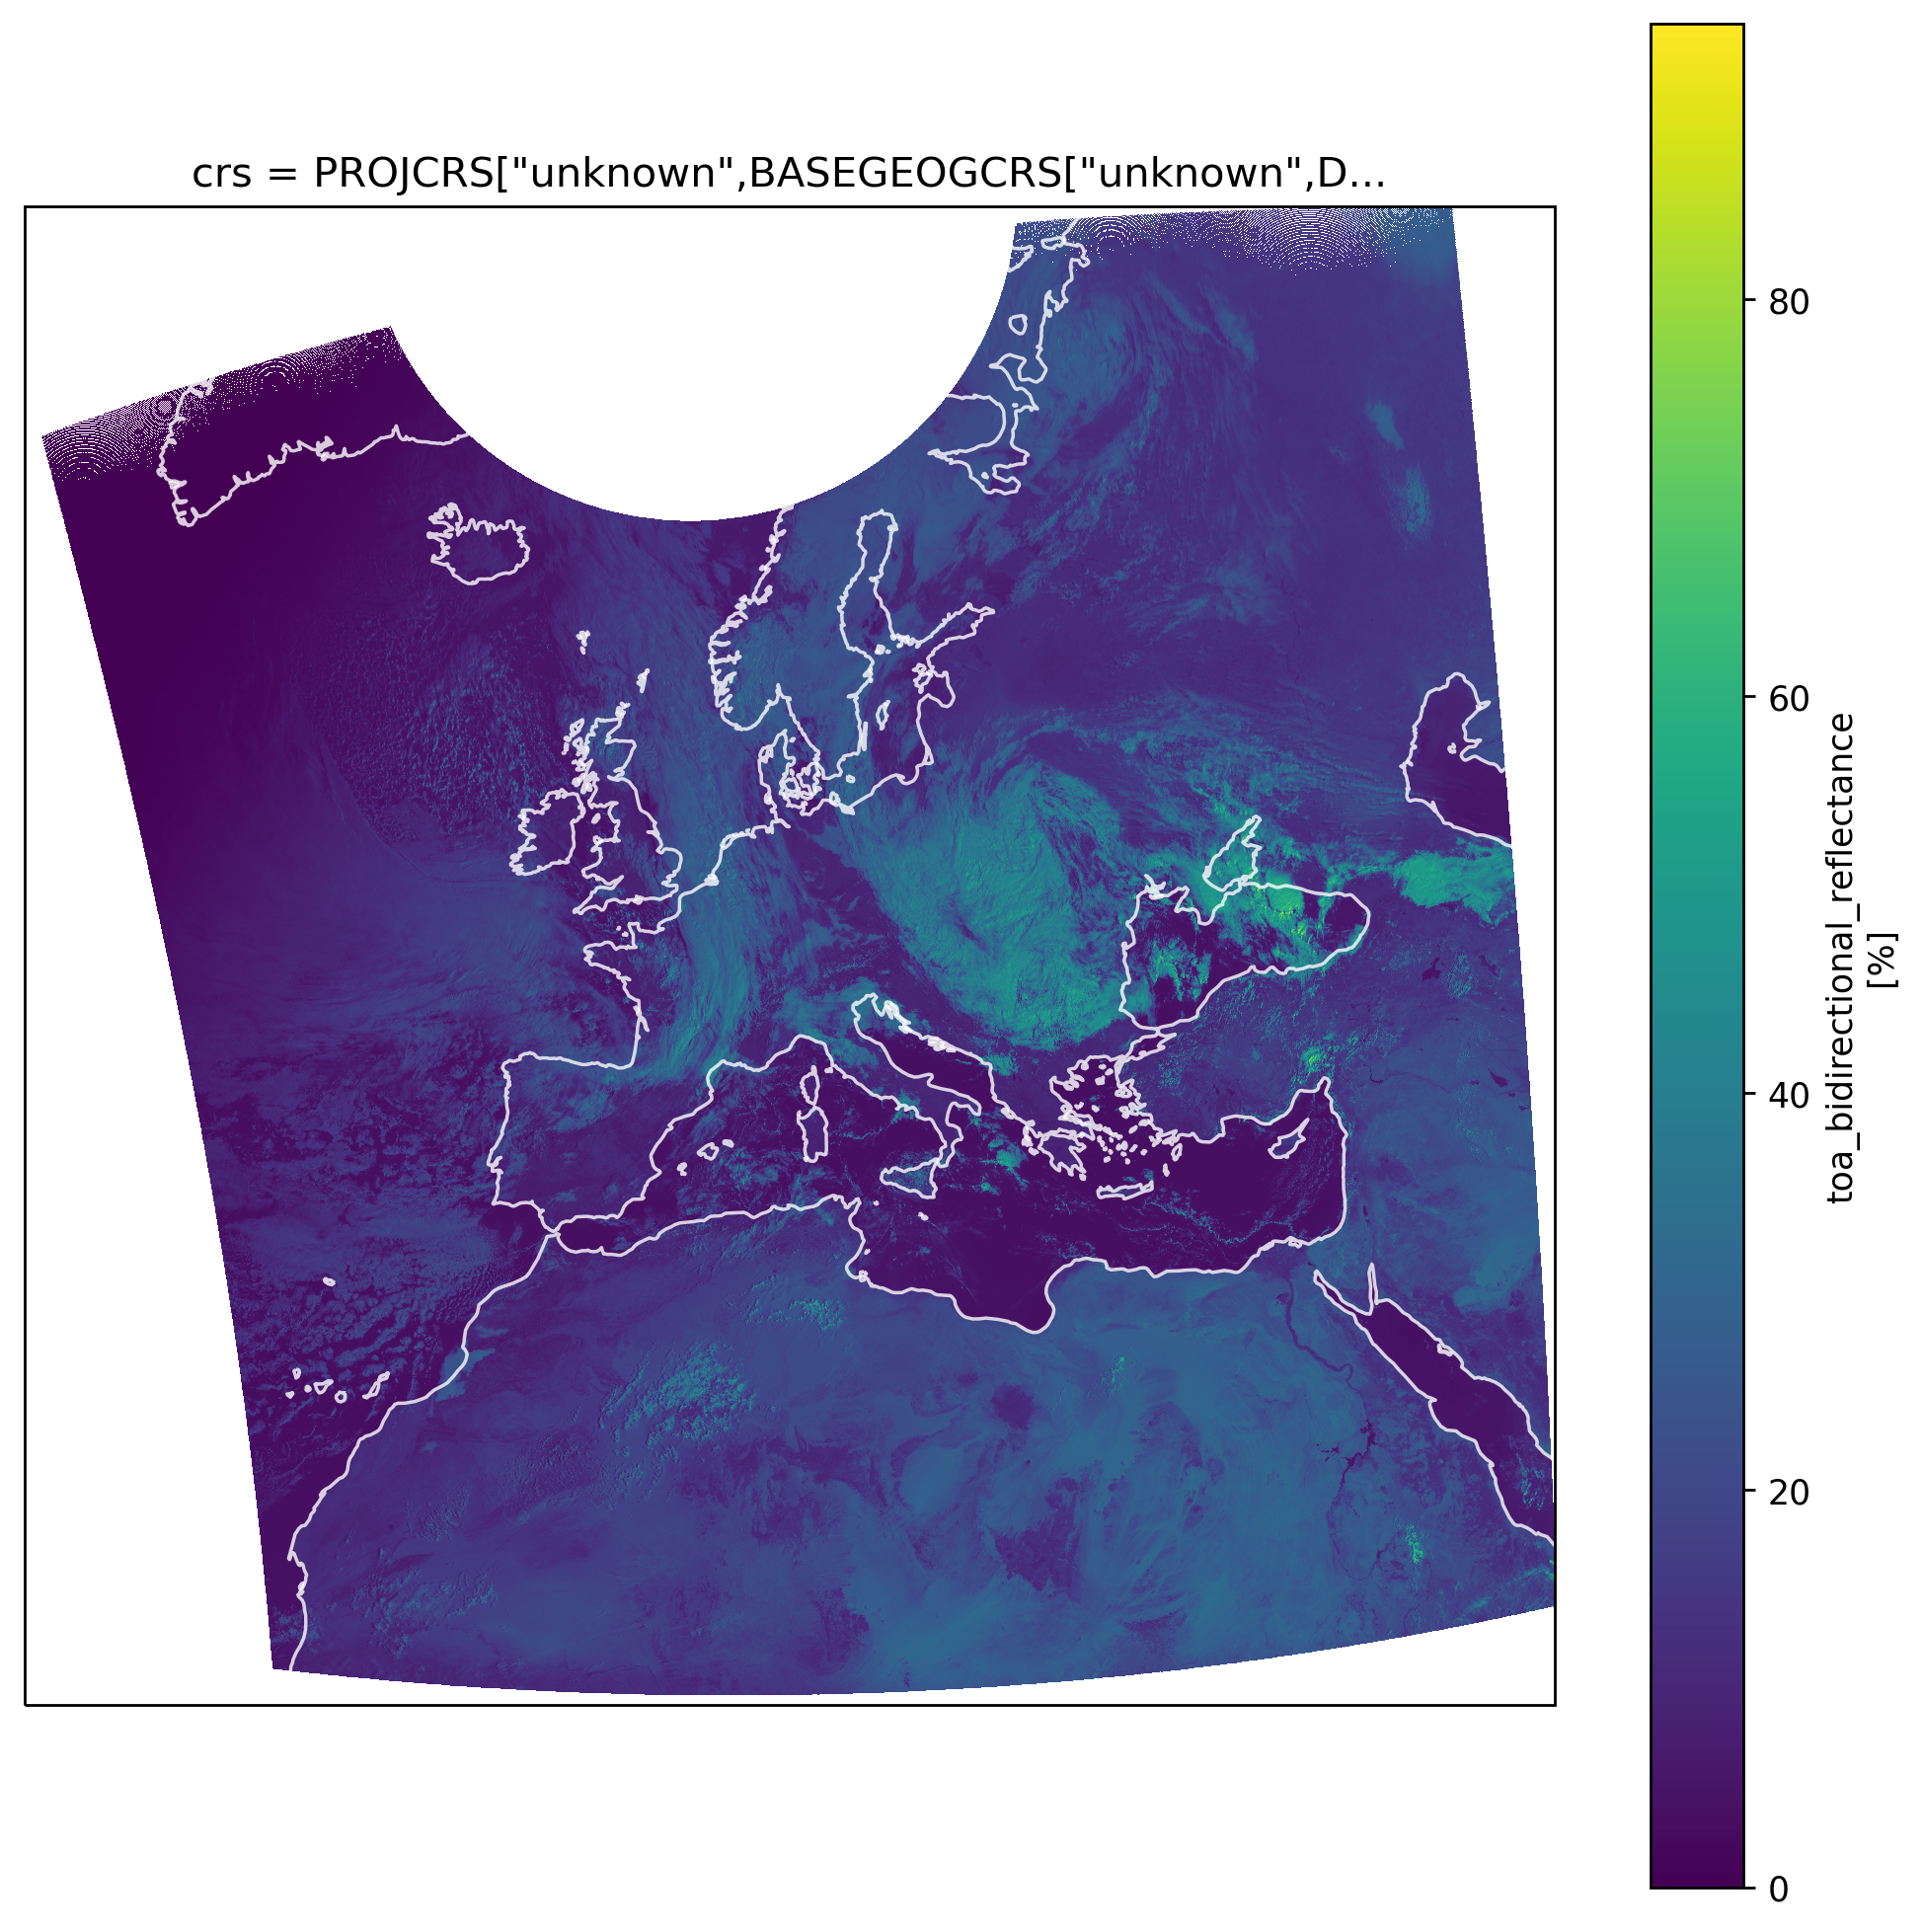

In [27]:
fig = plt.figure(dpi=250, figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

resampled_scene['HRV'].plot.imshow(ax=ax)

ax.coastlines(resolution='50m', alpha=0.8, color='white')